# Imports

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# Conditional gradient methods

### Implementation

In [41]:
def project_to_birkhoff_frank_wolfe(Y, max_iter=1000, tol=1e-6):
    """
    Projects matrix Y onto the Birkhoff polytope using the Frank-Wolfe algorithm.

    Args:
        Y (np.ndarray): The matrix to project.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence (change in objective value).

    Returns:
        np.ndarray: The projection of Y onto the Birkhoff polytope.
        list: History of objective function values.
    """
    n = Y.shape[0]
    assert Y.shape[0] == Y.shape[1], "Input matrix must be square"

    # Initialize with a feasible point (e.g., uniform matrix)
    Xk = np.ones((n, n)) / n

    objective_history = []

    for k in range(max_iter):
        # Objective function value
        obj_val = 0.5 * np.linalg.norm(Xk - Y, 'fro')**2
        objective_history.append(obj_val)

        diff = -1
        if k > 0:
            diff = abs(objective_history[-1] - objective_history[-2])

        if diff > 0 and diff < tol:
            print(f"Converged after {k} iterations.")
            break

        # 1. Compute gradient
        grad_fk = Xk - Y

        # 2. Solve the LMO: S_k = argmin_{S in Birkhoff} <grad_fk, S>
        # Use linear_sum_assignment on the cost matrix grad_fk
        row_ind, col_ind = linear_sum_assignment(Xk - Y, False)

        Sk = np.zeros((n, n))
        # Construct permutation matrix Sk based on row_ind, col_ind
        Sk[row_ind, col_ind] = 1

        # 3. Compute step size gamma_k
        # Optimal step size for projection, clipped to [0, 1]
        delta_k = Xk - Sk
        denom = np.linalg.norm(delta_k, 'fro')**2
        if denom < 1e-12: # Avoid division by zero if Xk is already the vertex Sk
            gamma_k = 0.0
        else:
            numerator = np.sum((Xk - Y) * (Xk - Sk))  # Frobenius inner product
            denominator = np.linalg.norm(Xk - Sk, 'fro')**2  # Squared Frobenius norm
            gamma_k = numerator / denominator
            gamma_k = np.clip(gamma_k, 0.0, 1.0)

        # 4. Update
        Xk = (1 - gamma_k) * Xk + gamma_k * Sk # YOUR CODE HERE 

    else: # If loop finishes without breaking
         print(f"Reached max iterations ({max_iter}).")

    return Xk, objective_history

### Testing

Reached max iterations (200).


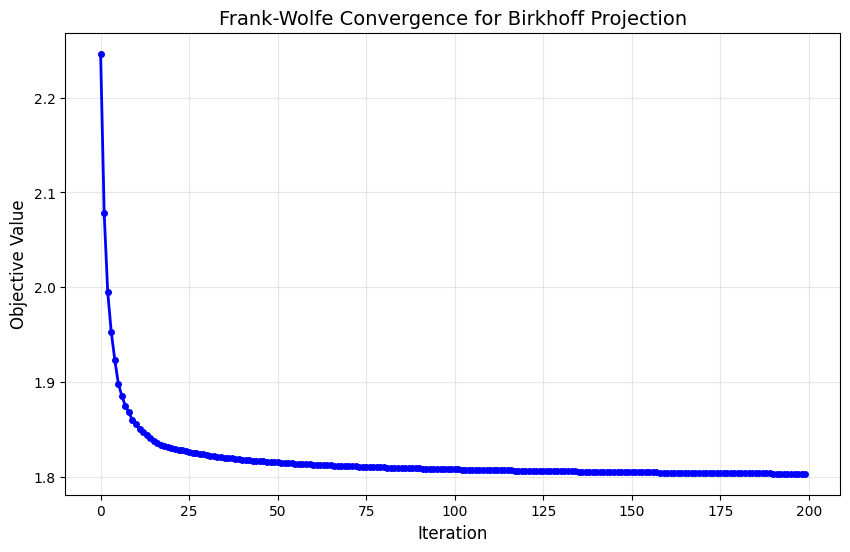

In [44]:
# Generate Y matrix
Y = np.random.rand(5, 5)

# Get algorithm results
X, objective_history = project_to_birkhoff_frank_wolfe(Y, max_iter=200)

# Plot history
plt.figure(figsize=(10, 6))
plt.plot(objective_history, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.title('Frank-Wolfe Convergence for Birkhoff Projection', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### Result veryfication

In [53]:
n = X.shape[0]

print(X)

for i in range(n):
  print(f'row {i} sum: {round(np.sum(X[i]), 2)} column {i} sum: {round(np.sum(X.T[i]), 2)}')

[[0.29691085 0.00856186 0.38962069 0.29634474 0.00856186]
 [0.00856186 0.16325243 0.16807486 0.12911151 0.53099934]
 [0.30549834 0.47059397 0.00856186 0.20678398 0.00856186]
 [0.26338695 0.27900795 0.34270118 0.00856186 0.10634207]
 [0.125642   0.0785838  0.09104141 0.35919791 0.34553488]]
row 0 sum: 1.0 column 0 sum: 1.0
row 1 sum: 1.0 column 1 sum: 1.0
row 2 sum: 1.0 column 2 sum: 1.0
row 3 sum: 1.0 column 3 sum: 1.0
row 4 sum: 1.0 column 4 sum: 1.0


Result: $X \in B_5$

# Subgradient method

### Implementation

In [24]:
# Define the loss function
def loss_function(A: np.ndarray, Sigma: np.ndarray, x: np.ndarray, y: np.ndarray):
  Uloss = np.clip(np.linalg.norm(sqrtm(A) @ (x - y), 2) - 1, a_min=0, a_max=np.inf)
  Vloss = np.clip(np.linalg.norm(Sigma @ x, ord=np.inf) - 1, a_min=0, a_max=np.inf)
  return Uloss + Vloss

# Set loss gradient
def loss_grad(A: np.ndarray, Sigma: np.ndarray, x: np.ndarray, y: np.ndarray): 
  Ugrad = np.zeros_like(x)
  Vgrad = np.zeros_like(x)
  Uloss = np.linalg.norm(sqrtm(A) @ (x - y), 2) - 1
  Vloss = np.linalg.norm(Sigma @ x, ord=np.inf) - 1
  if Uloss > 0:
    Ugrad = 2 * sqrtm(A).T @ sqrtm(A) @ (x - y)
  if Vloss > 0:
    sigma_vector = Sigma @ x
    Vgrad = np.zeros_like(sigma_vector)
    idx = np.argmax(sigma_vector)
    Vgrad[idx] = Sigma[idx, idx]

  return Ugrad + Vgrad

# Subgradient method function
def subgradient_method(A: np.ndarray, Sigma: np.ndarray, y: np.ndarray, max_iter=1000, tol=1e-6):
  n = y.shape[0]
  x = np.zeros_like(y)
  x_list = []
  loss_list = []

  for k in range(max_iter):
    grad = loss_grad(A, Sigma, x, y)
    loss = loss_function(A, Sigma, x, y)
    alpha = 0.01

    # Adaptive step count
    if k > 0:
      x = x - alpha * np.sqrt(1 / k) * grad
    else:
      x = x - alpha * grad

    # Add point and loss to list
    x_list.append(x)
    loss_list.append(loss)

    # Stop if we come to solvation
    if k > 0 and loss < tol:
      print(f"Converged after {k} iterations.")
      break

  else: # If loop finishes without breaking
    print(f"Reached max iterations ({max_iter}).")
  return x_list, loss_list
  

### Set data

In [25]:
# Set data
A = np.array(
  [
    [1, 0],
    [-1, 1]
  ]
)
y = np.array((3, 2)).T
Sigma = np.array(
  [
    [0.5, 0],
    [0, 1.]
  ]
)

x = np.array((1, 2)).T

### Method performance

Reached max iterations (2000).


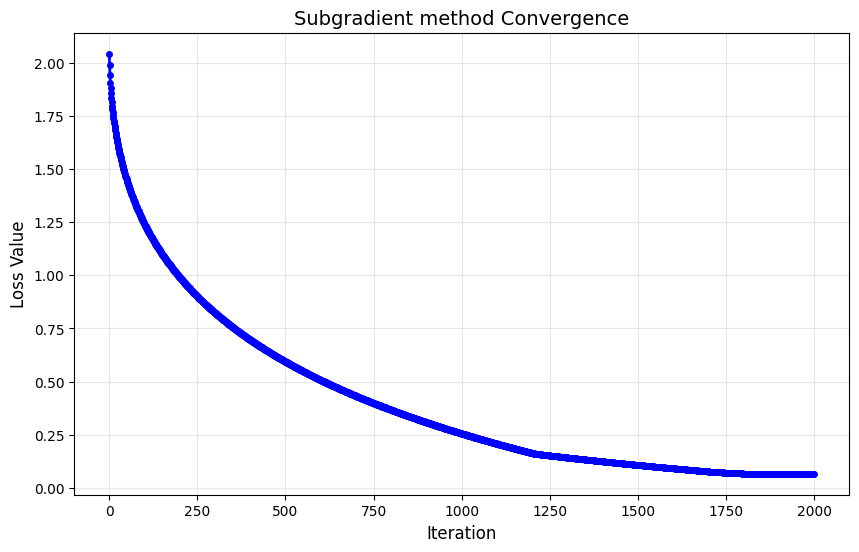

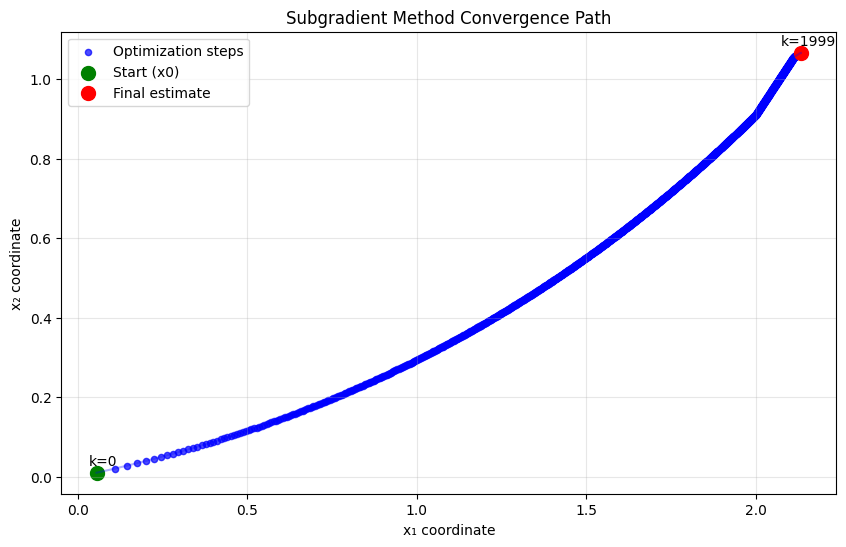

In [26]:
x_list, loss_list = subgradient_method(A, Sigma, y, max_iter=2000)

# Plot history
plt.figure(figsize=(10, 6))
plt.plot(loss_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Subgradient method Convergence', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot x-dots method convergence
# Convert x_list to plottable coordinates
x1_coords = [x[0] for x in x_list]
x2_coords = [x[1] for x in x_list]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the path as connected dots
plt.plot(x1_coords, x2_coords, 'b-', alpha=0.3)  # Thin blue line for path
plt.scatter(x1_coords, x2_coords, c='blue', s=20, alpha=0.7, label='Optimization steps')  # Dots

# Mark start and end points
plt.scatter(x1_coords[0], x2_coords[0], c='green', s=100, label='Start (x0)')
plt.scatter(x1_coords[-1], x2_coords[-1], c='red', s=100, label='Final estimate')

# Add iteration labels
plt.annotate(f'k={0}', (x_list[0][0], x_list[0][1]), textcoords="offset points", xytext=(5,5), ha='center')
plt.annotate(f'k={len(x_list) - 1}', (x_list[-1][0], x_list[-1][1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('x₁ coordinate')
plt.ylabel('x₂ coordinate')
plt.title('Subgradient Method Convergence Path')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Result: Method converged to sets crossing area